In [42]:
!pip install pydicom
!pip install opencv-python
!pip install numpy
!pip install matplotlib

In [43]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from glob import glob

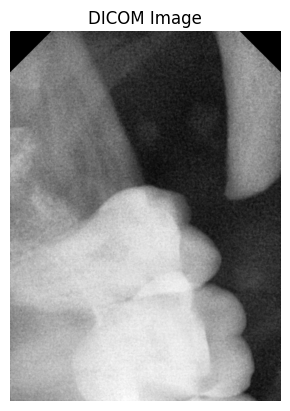

StudyDate: 20250115
SeriesDate: 20250115
StudyTime: 191316
SeriesTime: 191316
Modality: IO
Manufacturer: EWOOSOFT
PatientName:  kaushalya
PatientID: 20241118_173348
PatientBirthDate: 20240101
PatientSex: W
PatientAge: 1
SoftwareVersions: 3.1.5.1
ViewPosition: AP
InstanceNumber: 1
SamplesPerPixel: 1
PhotometricInterpretation: MONOCHROME2
Rows: 1095
Columns: 800
PixelSpacing: [0.0296, 0.0296]
BitsAllocated: 8
BitsStored: 8
HighBit: 7
WindowCenter: 127
WindowWidth: 255
RescaleSlope: 1
RescaleType: US
PixelData: b'\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [44]:
dcm_folder = "/content/Images_Data_science_intern"
dcm_files = glob(os.path.join(dcm_folder, "*.dcm"))

ds = pydicom.dcmread(dcm_files[0])
image = ds.pixel_array

plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')
plt.show()

for f in ds:
  if f.keyword and f.value:
    print(f"{f.keyword}: {f.value}")

In [45]:
def get_brightness(image):
  return np.mean(image)

def get_contrast(image):
  return np.std(image)

def get_sharpness(image):
  return cv2.Laplacian(image, cv2.CV_64F).var()

def get_estimated_noise(image):
  h, w = image.shape
  center = image[h//4:3*h//4, w//4:3*w//4]
  return np.std(center)

In [53]:
def static_preprocessing(image):

  equalization = cv2.equalizeHist(image)

  kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
  sharpened = cv2.filter2D(equalization, -1, kernel)
  return sharpened

def adaptive_preprocessing(image):

  brightness = get_brightness(image)
  contrast = get_contrast(image)
  sharpness = get_sharpness(image)
  noise = get_estimated_noise(image)

  result = image.copy()

  if contrast < 30:
    clahe = cv2.createCLAHE(cliplimit=2.0, titleGridSize=(8.8))
    result = clahe.apply(result)

  if sharpness < 100:
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    result = cv2.filter2D(result, -1, kernel)

  if noise > 25:
    result = cv2.fastNlMeansDenoising(result, h=10)

  return result

In [47]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate(original, processed):
  return {'SSIM': ssim(original, processed), 'PSNR': psnr(original,processed)}

In [63]:
def plot_save_comparison(original, static, adaptive, file):

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].imshow(original, cmap = 'gray')
  axes[0].set_title("Original")

  axes[1].imshow(static, cmap = 'gray')
  axes[1].set_title("Static")

  axes[2].imshow(adaptive, cmap = 'gray')
  axes[2].set_title("Adaptive")

  for axs in axes:
    axs.axis("off")

  plt.tight_layout()
  plt.savefig(f"comparison_f{file}")
  plt.show()
  plt.close()

In [57]:
def process_dcm_images(folder):

  dcm_files = glob(os.path.join(dcm_folder, "*.dcm"))

  results = []

  for file in dcm_files:
    ds = pydicom.dcmread(file)
    image = ds.pixel_array.astype(np.uint8)

    metrics = {
            'File': os.path.basename(file),
            'Brightness': get_brightness(image),
            'Contrast': get_contrast(image),
            'Sharpness': get_sharpness(image),
            'Noise': get_estimated_noise(image),
        }

    static = static_preprocessing(image)
    adaptive = adaptive_preprocessing(image)

    static_eval = evaluate(image, static)
    adaptive_eval = evaluate(image, adaptive)

    file_name = os.path.splitext(os.path.basename(file))[0]
    plot_save_comparison(image, static, adaptive, file_name)

    metrics.update({
        'SSIM_Static': static_eval['SSIM'],
        'PSNR_Static': static_eval['PSNR'],
        'SSIM_Adaptive': adaptive_eval['SSIM'],
        'PSNR_Adaptive': adaptive_eval['PSNR']
    })

    results.append(metrics)

  return results

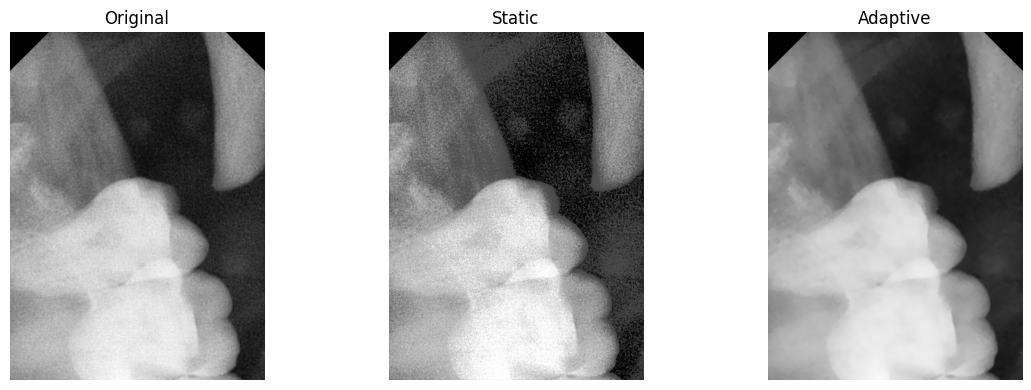

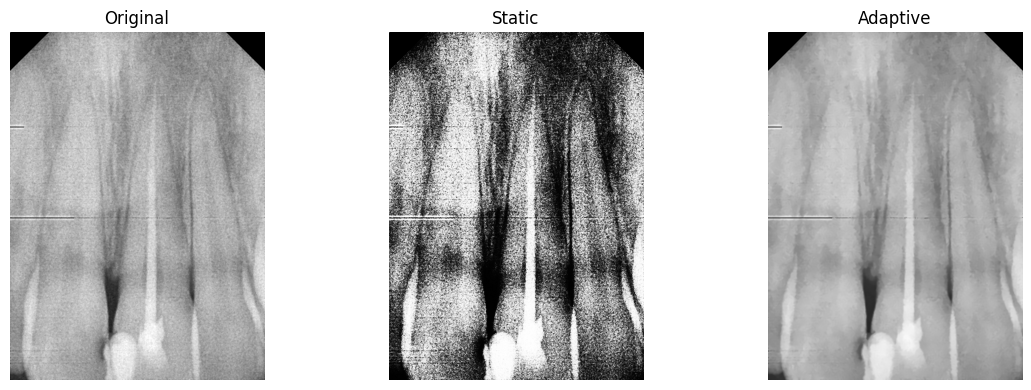

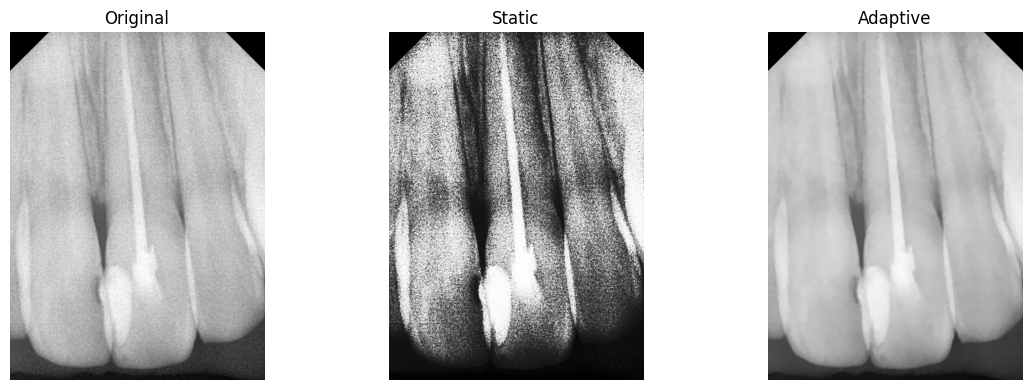

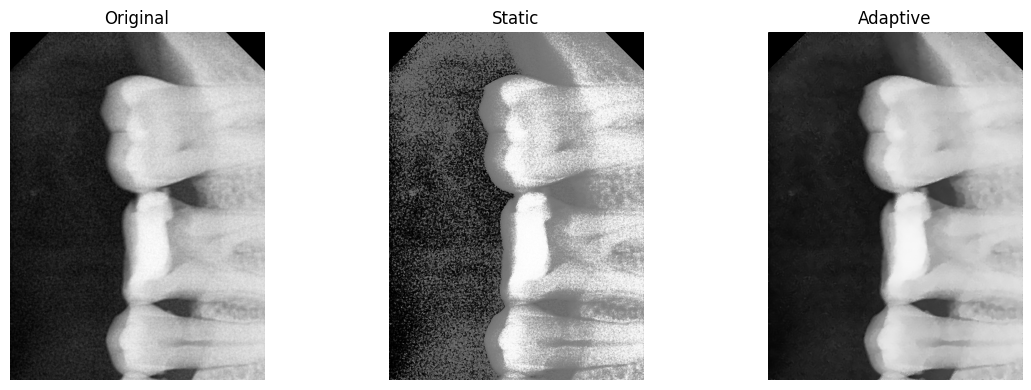

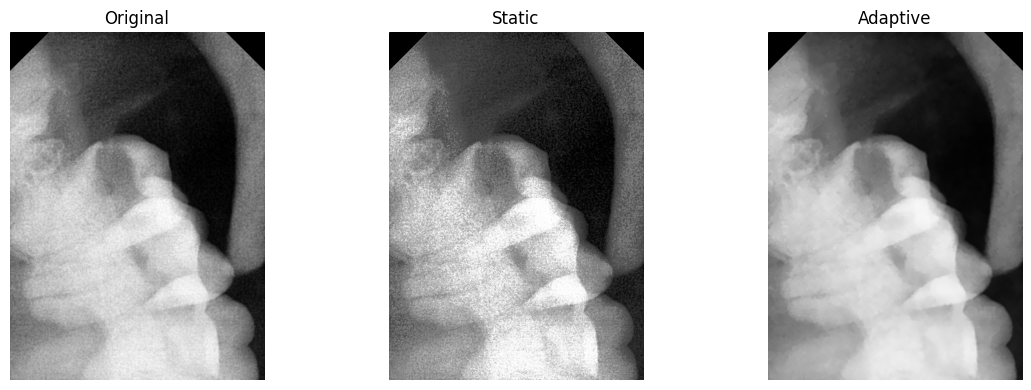

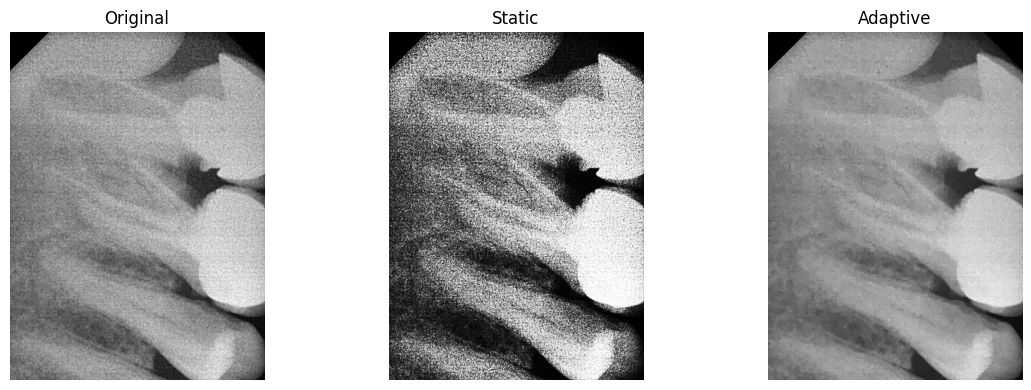

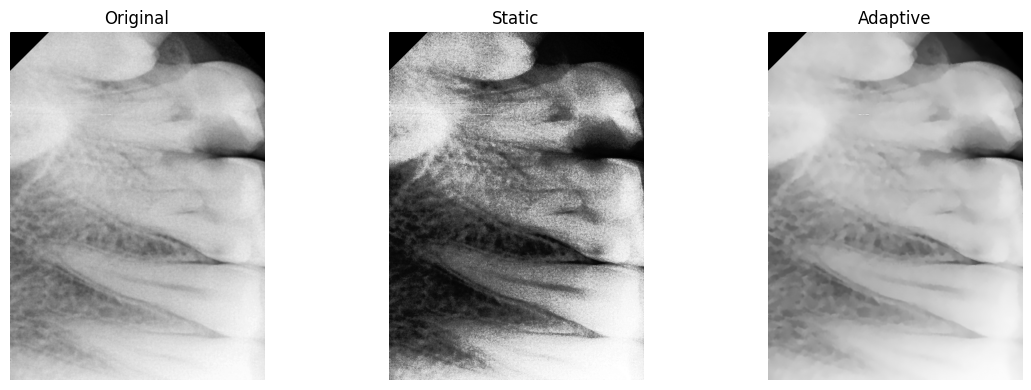

{'File': 'IS20250115_191316_7227_10120577.dcm', 'Brightness': np.float64(127.77649086757991), 'Contrast': np.float64(72.30086550835173), 'Sharpness': np.float64(101.51437962794768), 'Noise': np.float64(77.33639993723048), 'SSIM_Static': np.float64(0.6227009958012271), 'PSNR_Static': np.float64(24.815757241869715), 'SSIM_Adaptive': np.float64(0.7973991328132963), 'PSNR_Adaptive': np.float64(34.30529819123349)}
{'File': 'IS20250218_193621_8940_10081171.dcm', 'Brightness': np.float64(166.89680251141553), 'Contrast': np.float64(34.428060059440355), 'Sharpness': np.float64(236.9231397100756), 'Noise': np.float64(28.89571119960987), 'SSIM_Static': np.float64(0.25075174808506423), 'PSNR_Static': np.float64(10.303843329811858), 'SSIM_Adaptive': np.float64(0.7331041191450252), 'PSNR_Adaptive': np.float64(31.858019042165463)}
{'File': 'IS20250218_193552_3393_78829426.dcm', 'Brightness': np.float64(175.43420433789953), 'Contrast': np.float64(50.17365742340646), 'Sharpness': np.float64(175.6981203

In [64]:
output = process_dcm_images(dcm_folder)

for r in output:
  print(r)